# Assignment on Panel Data:
_Empirical Replication of Adema and Pozzi (2015)_

### Dante van der Heijden (11020075), Willem Kullberg (11041544) and Wietse Steenstra (11004487)

In this assignment, we replicate and extend some of the empirical results in Adema and Pozzi (2015). 
The dataset together with the data description is provided on Canvas. 
In particular, we are interested in replicating the results in Tables 2-3 of that paper. 
Before proceeding with the tasks described in this section, `read carefully Adema and Pozzi (2015)`. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import random
import tqdm

We import CSV file and create three new RHS variables: two lags - $\Delta s_{i,t-1}$, $\Delta y_{i,t-1}$,  and one lead variable $\Delta y_{i,t+1}$. Notice that your LHS variable of interest is $\Delta s_{i,t}$.

In [2]:
sCol = ['ID', 'Time', 'DeltaS', 'DeltaY']
df = pd.read_csv('Data.txt', delimiter = "\t",header=None,usecols=[0,1,2,9], names=sCol )
df['DeltaS_lag'] = df.groupby(['ID'])['DeltaS'].shift(1)
df['DeltaY_lag'] = df.groupby(['ID'])['DeltaY'].shift(1)
df['DeltaY_lead'] = df.groupby(['ID'])['DeltaY'].shift(-1)

As it is mentioned by the authors, for some countries data in the beginning of the sample is not available. To simplify your analysis, please consider only data from `1971-2012 for 14 countries`, i.e. drop Denmark and Ireland from your sample. Notice that because the empirical model has leads and lags of RHS variables the effective length of your panel variables is only $41+1-2=40$.

In [3]:
df = df.drop(df[df.ID==5].index)
df = df.drop(df[df.ID==9].index)
df = df.drop(df[df.Time <1972].index)
df = df.drop(df[df.Time >2011].index)

df

,ID,Time,DeltaS,DeltaY,DeltaS_lag,DeltaY_lag,DeltaY_lead
3,1,1972,0.010026,0.023169,0.021553,0.038489,0.043908
4,1,1973,0.020100,0.043908,0.010026,0.023169,0.015815
5,1,1974,0.004775,0.015815,0.020100,0.043908,0.023548
6,1,1975,0.002466,0.023548,0.004775,0.015815,0.039224
7,1,1976,-0.029913,0.039224,0.002466,0.023548,0.014483
...,...,...,...,...,...,...,...
698,16,2007,-0.003379,0.017899,0.007767,0.026667,-0.002906
699,16,2008,0.019948,-0.002906,-0.003379,0.017899,-0.028021
700,16,2009,0.011181,-0.028021,0.019948,-0.002906,0.025068
701,16,2010,-0.004909,0.025068,0.011181,-0.028021,0.018473


Can we learn anything from pooled regression of $\Delta s_{i,t}$ on $\Delta y_{i,t}$? Not really...

<AxesSubplot:xlabel='DeltaY'>

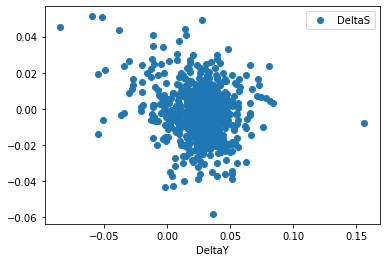

In [4]:
df.plot(x='DeltaY', y='DeltaS', style='o')

I find it useful to have all regressors in the format of an array $[K x T x N]$.

In [5]:
def PrepareData (df, iSizeN, iSizeT, sCol):
    
    mDataY  = np.transpose(np.asmatrix(df[sCol[0]].values).reshape(iSizeN,iSizeT))
    iSizeK = np.int(np.size(sCol)-1)
    
    aX = np.empty((iSizeK,iSizeT,iSizeN))

    for k in range (0,iSizeK):
        aX[k,:,:] = np.transpose(np.asmatrix(df[sCol[k+1]].values).reshape(iSizeN,iSizeT))
        
        
    return (mDataY,aX)

In [6]:
mDataY, aX = PrepareData (df, 14, 40, ['DeltaS','DeltaS_lag','DeltaY_lag','DeltaY','DeltaY_lead'])

You might also find useful to construct the orthogonal projection matrix $\boldsymbol{M_{F}=I-F(F'F)^{-1}F'}$ for any $[T x L]$ matrix $\boldsymbol{F}$. For example

In [7]:
def FETrans (mF):
    
    iSizeT = np.shape(mF)[0]

    return np.identity(iSizeT) - mF @ np.linalg.inv(mF.T@ mF/iSizeT)@ mF.T/iSizeT

Note that this approach is only applicable for balanced panels, where the elimination of unit-specific and time-specific additive effects can be expressed using these matrices. Alternatively, you can use groupby options and remove unit-specific and time-specific effects directly from the dataframe.

For the pooled estimator it is convenenient to transform $[K x T x N]$ array into a $[K x NT]$ matrix. The function below does this for you efficiently. For example, your pooled estimator can be expressed as $(X'X)^{-1}X'y$ where $X$ is a $[NT x K]$. Notice that this function also pre-multiplies every regressor by $\boldsymbol{M_{F}=I-F(F'F)^{-1}F'}$ first, before doing any manipulation. Time effects should be removed beforehand.

In [8]:
def FlatArray(aData, mF):
    
    iSizeK, iSizeT, iSizeN = np.shape(aData)
    iLength = int(iSizeT*iSizeN)
    aMultT = np.broadcast_to(mF,(iSizeK,)+mF.shape)
    aDataTrans = np.transpose(np.matmul(aMultT,aData),(0,2,1))
    
    return aDataTrans.reshape(iSizeK,iLength)

For Mean group estimators, you need individual specific coefficients $\hat{\theta}_{i}$. You can either do it by: a) looping over $[KxTx [i]]$ for all $i$ and then do unit-by-unit OLS; b) avoid loops and operate on arrays directly. The second option is much faster (of order >10 times faster) but is more difficult to program. Option b) is essentially required only if you want to do fancy bootstrap where coefficients need to be re-estimated $B$ times. This is not needed in your exercise

Finally, how can we efficiently remove time effects from a balanced panel?

In [9]:
# construct [N x N] matrix, where N=14
mTransN = FETrans(np.ones((14,1)))
# create [K x N x Na array where for every k=1,...,K you have mTransN as an input
aTransX = np.broadcast_to(mTransN,(int(np.shape(aX)[0]),)+mTransN.shape)
# pre-multiply every regressor from the right (i.e. the N dimension)
aX = np.matmul(aX,aTransX)

# the final result is a [K x T x N] array


You might also find this function useful when calculating Heteroscedasticity and autocorrelation robust S.E. (CCM estimator) for the FE estimator (with or without time-effects)

In [10]:
def FEScore (mF, mDataY, aX, vBeta):
    
    iSizeK, iSizeT, iSizeN = np.shape(aX)

    vBeta = np.array(vBeta)
    mTrans = FETrans(mF)
    mE = mDataY - np.sum(np.multiply(aX, vBeta.reshape(iSizeK,1,1)),axis=0)
    mE = mTrans@mE
    aE = np.broadcast_to(mE,(iSizeK,)+mE.shape)
    aW = np.multiply(aX,aE)

    return aW

This function creates a $[K x T x N]$ array with elements $w_{i,t}^{(k)}=x_{i,t}^{(k)}\widehat{\varepsilon}_{i,t}$. You can then use this input to calculate the CCM matrix estimator, using average over one of the dimension.

### Question 1: 
Given that sample size is limited to N = 14, can one expect to get reasonable
statistical precision based on pooled estimators? Mean-group estimator?

**Answer:** Each individual estimator likely has sizable error and won't be very precise. According Pesaran and Smith (1995), the pooled estimators are generally inconsistent estimates for average effects (as Adema and Pozzi, 2015 write). The mean-group estimators could be consistent as long as the $\hat{\beta}_i$'s are consistent and due to averaging their standard error will decrease to an acceptable size.

### Question 2: 
Consider empirical specifications in Column 4 of Tables 2 and 3. Provide estimation
(no testing for now) results for:

### Question 2A
Pooled (homogenous estimators): FE (without time-effects). FE (with
time-effects) - 2W-FE.

In [11]:
# Calculate average of variables over time and individual dimension
def meaner(col1, col2):
    letter = col1.name[0]
    return_df = df.groupby(col1.name).mean().drop(col2.name, axis=1)
    return_df.columns = ['avg' + letter + '_' + str(col) for col in return_df.columns]
    return return_df

# Define list of X_vars
X_vars = ['DeltaY', 'DeltaS_lag', 'DeltaY_lag', 'DeltaY_lead']

In [12]:
def TWFE(df):
    T_means = meaner(df['Time'],df['ID'])
    I_means = meaner(df['ID'], df['Time'])

    # Merge time and individual averages back to dataframe
    df_full = df.merge(T_means, how = 'left', left_on = 'Time', right_on = 'Time')
    df_full = df_full.merge(I_means, how = 'left', left_on = 'ID', right_on = 'ID')
    
    ### FE with and without time-effects

    # Calculate time demeaned X tilde and y tilde from lecture 1 slide 36
    y = df_full['DeltaS'] - df_full['avgI_DeltaS']
    X = df_full[X_vars] - df_full[I_means.columns].drop('avgI_DeltaS',axis=1).values

    # Same X and y, but now also subtract the individual means
    y_time = y - df_full['avgT_DeltaS']
    X_time = X - df_full[T_means.columns].drop('avgT_DeltaS',axis=1).values

    beta_FE = np.linalg.inv(np.matrix(X).T @ np.matrix(X)) @ X.T @ y
    beta_FE_time = np.linalg.inv(np.matrix(X_time).T @ np.matrix(X_time)) @ X_time.T @ y_time
    
    res_FE = y - X @ np.array(beta_FE)
    res_FE_time = y_time - X_time @ np.array(beta_FE_time)
    
    return np.array(beta_FE), np.array(beta_FE_time), y, X, y_time, X_time, np.matrix(res_FE).T, np.matrix(res_FE_time).T

beta_FE, beta_FE_time, y, X, y_time, X_time, res_FE, res_FE_time = TWFE(df)

# Print
print("No time effects:")
for i in range(len(beta_FE)):
    print('{}: {}'.format(X.columns[i], round(beta_FE[i],4)))
    
print("\nWith time effects:")
for i in range(len(beta_FE)):
    print('{}: {}'.format(X.columns[i], round(beta_FE_time[i],4)))

No time effects:
DeltaY: -0.157
DeltaS_lag: 0.0555
DeltaY_lag: 0.1312
DeltaY_lead: -0.0539

With time effects:
DeltaY: -0.0798
DeltaS_lag: 0.0222
DeltaY_lag: 0.0211
DeltaY_lead: -0.0017


**Answer:** The estimators without time effects can be compared to table 3, column (4) of Adema and Pozzi (2015). We see reasonably similar results. The discrepancies that are left could be explained by the sampling; we dropped two countries and only looked at the time period from 1971 to 2012.
The estimators with time effects lead to fairly different results than the ones without. Although we do not see sign changes, we do see very different values and different order of magnitudes of the estimators. So if the true model would in fact have time effects, the model proposed by Adema and Pozzi (2015) would give incorrect results.

**Moet nog over CI bij, en dus niet zeker over de of je nou met time effect of zonder time effect moet vergelijken**



### Question 2B
Estimate the pooled Half Panel Jackknife estimator for FE and 2W-FE.

In [13]:
### Pooled Half Panel Jackknife
def jackknife(df):
    # Split up panel in two halves
    df_part_first_half = df[df['Time'] < 1992]
    df_part_second_half = df[df['Time'] >= 1992]

    T_means = meaner(df_part_first_half['Time'],df_part_first_half['ID'])
    I_means = meaner(df_part_first_half['ID'], df_part_first_half['Time'])

    # Merge time and individual averages back to dataframe
    df_first_half = df_part_first_half.merge(T_means, how = 'left', left_on = 'Time', right_on = 'Time')
    df_first_half = df_first_half.merge(I_means, how = 'left', left_on = 'ID', right_on = 'ID')

    T_means = meaner(df_part_second_half['Time'],df_part_second_half['ID'])
    I_means = meaner(df_part_second_half['ID'], df_part_second_half['Time'])

    # Merge time and individual averages back to dataframe
    df_second_half = df_part_second_half.merge(T_means, how = 'left', left_on = 'Time', right_on = 'Time')
    df_second_half = df_second_half.merge(I_means, how = 'left', left_on = 'ID', right_on = 'ID')

    # Get X and y from half panels
    y_first =  df_first_half['DeltaS'] - df_first_half['avgI_DeltaS'] # Without time effects
    y_second = df_second_half['DeltaS'] - df_second_half['avgI_DeltaS']
    X_first = df_first_half[X_vars] - df_first_half[I_means.columns].drop('avgI_DeltaS',axis=1).values
    X_second = df_second_half[X_vars] - df_second_half[I_means.columns].drop('avgI_DeltaS',axis=1).values

    y_time_first = y_first - df_first_half['avgT_DeltaS'] # With time effects
    y_time_second = y_second - df_second_half['avgT_DeltaS']
    X_time_first = X_first - df_first_half[T_means.columns].drop('avgT_DeltaS',axis=1).values
    X_time_second = X_second - df_second_half[T_means.columns].drop('avgT_DeltaS',axis=1).values

    # Calculate betas for half panels
    beta_first = np.linalg.inv(np.matrix(X_first).T @ np.matrix(X_first)) @ X_first.T @ y_first
    beta_second = np.linalg.inv(np.matrix(X_second).T @ np.matrix(X_second)) @ X_second.T @ y_second

    beta_first_time = np.linalg.inv(np.matrix(X_time_first).T @ np.matrix(X_time_first)) @ X_time_first.T @ y_time_first
    beta_second_time = np.linalg.inv(np.matrix(X_time_second).T @ np.matrix(X_time_second)) @ X_time_second.T @ y_time_second

    # Calculate half panel jackknifes
    beta_HPJack = beta_FE * 2 - 0.5*(beta_first + beta_second)  # Without time effects
    beta_HPJack_time = beta_FE_time * 2 - 0.5*(beta_first_time + beta_second_time) # With time effects
    
    res_HPJack = y - X @ np.array(beta_HPJack)
    res_HPJack_time = y_time - X_time @ np.array(beta_HPJack_time)
    
    return np.array(beta_HPJack), np.array(beta_HPJack_time), np.matrix(res_HPJack).T, np.matrix(res_HPJack_time).T

beta_HPJack, beta_HPJack_time, res_HPJack, res_HPJack_time = jackknife(df)

# Print
print("Pooled Half-Panel JackKnife (Bias-Corrected)\n")
print("No time effects:")
for i in range(len(beta_FE)):
    print('{}: {}'.format(X.columns[[1,2,0,3]][i], round(np.array(beta_HPJack[[1,2,0,3]])[i],4)))
    
print("\nWith time effects:")
for i in range(len(beta_FE)):
    print('{}: {}'.format(X.columns[[1,2,0,3]][i], round(np.array(beta_HPJack_time[[1,2,0,3]])[i],4)))

Pooled Half-Panel JackKnife (Bias-Corrected)

No time effects:
DeltaS_lag: 0.0661
DeltaY_lag: 0.132
DeltaY: -0.1451
DeltaY_lead: -0.0535

With time effects:
DeltaS_lag: 0.0221
DeltaY_lag: 0.0197
DeltaY: -0.077
DeltaY_lead: -0.0028


**Answer:** Again, comparing to table 3 of Adema & Pozzi (2015), ... kan nog veranderen

### Question 2C
Estimate the mean group estimators: MG and HPJ-MG. (both without time-effects).

In [14]:
# Initialize variables
beta_total_MG = np.zeros([len(df['ID'].unique()), len(X_vars)])
beta_total_HPJ_MG = np.zeros([len(df['ID'].unique()), len(X_vars)])
i=0

# Loop over all individuals
for individual in df['ID'].unique():
    
    ### MEAN GROUP ESTIMATOR
    
    # Filter df to only include observations for one individual
    df_i = df[df['ID'] == individual]
    
    # Find time averages to demean
    I_means = meaner(df_i['ID'],df_i['Time'])
    df_ind = df_i.merge(I_means, how = 'left', left_on = 'ID', right_on = 'ID')
    
    # Get y and X
    y_ind = df_ind['DeltaS'] - df_ind['avgI_DeltaS']
    X_ind = df_ind[X_vars] - df_ind[I_means.columns].drop('avgI_DeltaS',axis=1).values
    
    # Calculate individual betas
    beta_ind = np.linalg.inv(np.matrix(X_ind).T @ np.matrix(X_ind)) @ X_ind.T @ y_ind
    beta_total_MG[i,:] = beta_ind
    
    
    ### MEAN GROUP HALF PANEL ESTIMATOR
    
    # Split individual dataset in two halves
    df_ind_first = df_i[df_i['Time']<1992]
    df_ind_second = df_i[df_i['Time']>=1992]
    
    # Find time averages to demean
    I_means_first = meaner(df_ind_first['ID'],df_ind_first['Time'])
    I_means_second = meaner(df_ind_second['ID'],df_ind_second['Time'])
    df_ind_first = df_ind_first.merge(I_means_first, how = 'left', left_on = 'ID', right_on = 'ID')
    df_ind_second = df_ind_second.merge(I_means_second, how = 'left', left_on = 'ID', right_on = 'ID')
    
    # Get y and X
    y_ind_first = df_ind_first['DeltaS'] - df_ind_first['avgI_DeltaS']
    y_ind_second = df_ind_second['DeltaS'] - df_ind_second['avgI_DeltaS']
    X_ind_first = df_ind_first[X_vars] - df_ind_first[I_means.columns].drop('avgI_DeltaS',axis=1).values
    X_ind_second = df_ind_second[X_vars] - df_ind_second[I_means.columns].drop('avgI_DeltaS',axis=1).values 
    
    beta_first = np.linalg.inv(np.matrix(X_ind_first).T @ np.matrix(X_ind_first)) @ X_ind_first.T @ y_ind_first
    beta_second = np.linalg.inv(np.matrix(X_ind_second).T @ np.matrix(X_ind_second)) @ X_ind_second.T @ y_ind_second
    beta_total_HPJ_MG[i,:] = 2 * beta_ind - 0.5 * (beta_first + beta_second)
    
    i = i + 1
    
beta_MG = np.mean(beta_total_MG,axis=0)
beta_HPJ_MG = np.mean(beta_total_HPJ_MG,axis=0)

# Print
print("Mean group estimator:")
for i in range(len(beta_FE)):
    print('{}: {}'.format(X.columns[[1,2,0,3]][i], round(np.array(beta_MG[[1,2,0,3]])[i],4)))
    
print("\nHalf Panel Jackknife Mean group estimator:")
for i in range(len(beta_FE)):
    print('{}: {}'.format(X.columns[[1,2,0,3]][i], round(np.array(beta_HPJ_MG[[1,2,0,3]])[i],4)))

Mean group estimator:
DeltaS_lag: 0.0221
DeltaY_lag: 0.1393
DeltaY: -0.17
DeltaY_lead: -0.0421

Half Panel Jackknife Mean group estimator:
DeltaS_lag: 0.0292
DeltaY_lag: 0.1419
DeltaY: -0.139
DeltaY_lead: -0.046


### Question 2D
Do you obtain similar conclusions as the authors, when you use the bias-corrected
versions of the estimators as opposed to standard versions of the estimators?


**Answer:** hangt ook nog af van wat er verandert, maar in principe wel

### Question 3: 
Consider testing.

• (L1) For all pooled estimators provide percentile bootstrap confidence intervals
with B = 400.

In [15]:
B = 399
n,p = X.shape

# initilize bootstrap arrays
betaB_FE = np.zeros((B,4))
betaB_FE_time = np.zeros((B,4))
betaB_HPJack = np.zeros((B,4))
betaB_HPJack_time = np.zeros((B,4))

np.random.seed(1)

# balanced bootstap
index_B = np.random.permutation(np.repeat(np.arange(n),B)).reshape((B,n))

# start the bootstrap, using tqdm to show a progress bar (install it using pip install tqdm)
for b in tqdm.tqdm(range(B)):
    index = index_B[b,:]  # select the indices
    # resample the dataset, and use this resampled dataset to create new betas
    dfB = pd.DataFrame.copy(df.iloc[index])
    betaB_FE[b,:], betaB_FE_time[b,:], yB, XB, yBT, XBT, resB_FE, resB_FE_time = TWFE(dfB)
    betaB_HPJack[b,:], betaB_HPJack_time[b,:], resB_HPJack, resB_HPJack_time = jackknife(dfB)

# percentile
q_bB_FE = np.quantile(betaB_FE,[0.025,0.975],axis=0)
q_bB_FE_time  = np.quantile(betaB_FE_time,[0.025,0.975],axis=0)
q_bB_HPJack = np.quantile(betaB_HPJack,[0.025,0.975],axis=0)
q_bB_HPJack_time = np.quantile(betaB_HPJack_time,[0.025,0.975],axis=0)

100%|██████████| 399/399 [00:19<00:00, 20.05it/s]


In [16]:
print('Percentile bootstrap CI without time effects')
print(q_bB_FE)
print('Percentile bootstrap CI with time effects')
print(q_bB_FE_time)
print('Percentile bootstrap using Jackknife CI without time effects')
print(q_bB_HPJack)
print('Percentile bootstrap using Jackknife CI with time effects')
print(q_bB_HPJack_time)

Percentile bootstrap CI without time effects
[[-0.23387217 -0.0437622   0.06882747 -0.11510313]
 [-0.08657401  0.15478094  0.19966359  0.00441884]]
Percentile bootstrap CI with time effects
[[-0.14954022 -0.0668035  -0.03755506 -0.07434526]
 [ 0.0084766   0.11400469  0.08652466  0.06504737]]
Percentile bootstrap using Jackknife CI without time effects
[[-0.21815966 -0.02913052  0.06228003 -0.10973265]
 [-0.0759432   0.16268135  0.19258964  0.00678901]]
Percentile bootstrap using Jackknife CI with time effects
[[-0.17356993 -0.07124019 -0.06453492 -0.07799358]
 [ 0.0153904   0.1103054   0.08095912  0.07925899]]


• (L1) You can also try normal approximation based CI using the CCM variancecovariance estimator.
January 3, 2021

In [26]:
# create omegas according to slide 44 L1

omega = np.linalg.inv(X.T@X/len(X)) @ X.T@res_FE@res_FE.T@X @ np.linalg.inv(X.T@X/len(X))
omega_time = np.linalg.inv(X_time.T@X/len(X_time)) @ X_time.T@res_FE_time@res_FE_time.T@X_time @ np.linalg.inv(X_time.T@X_time/len(X))
omega_jack = np.linalg.inv(X.T@X/len(X)) @ X.T@res_HPJack@res_HPJack.T@X @ np.linalg.inv(X.T@X/len(X))
omega_jack_time = np.linalg.inv(X_time.T@X/len(X_time)) @ X_time.T@res_HPJack_time@res_HPJack_time.T@X_time @ np.linalg.inv(X_time.T@X/len(X_time))

# use these omegas to create CIs
CI_FE = [list(beta_FE - 1.96 * np.diag(np.sqrt(omega)/len(X))), list(beta_FE + 1.96 * np.diag(np.sqrt(omega)/len(X)))]
CI_FE_time = [list(beta_FE - 1.96 * np.diag(np.sqrt(omega_time)/len(X))), list(beta_FE + 1.96 * np.diag(np.sqrt(omega_time)/len(X)))]
CI_HPJack = [list(beta_FE - 1.96 * np.diag(np.sqrt(omega_jack)/len(X))), list(beta_FE + 1.96 * np.diag(np.sqrt(omega_jack)/len(X)))]
CI_HPJack_time = [list(beta_FE - 1.96 * np.diag(np.sqrt(omega_jack_time)/len(X))), list(beta_FE + 1.96 * np.diag(np.sqrt(omega_jack_time)/len(X)))]

array([[2484.98102403,  206.00675797, -763.96964384, -775.88645875],
       [ 206.00675797, 4468.06430601,  528.34466819,  229.35166573],
       [-763.96964384,  528.34466819, 2279.36385815,  252.95799111],
       [-775.88645875,  229.35166573,  252.95799111, 2275.08195712]])

In [27]:
print('Confidence interval without time effects')
print(CI_FE[0])
print('and')
print(CI_FE[1])
print('\nConfidence interval with time effects')
print(CI_FE_time[0])
print('and')
print(CI_FE_time[1])
print('\nConfidence interval HPJack without time effects')
print(CI_HPJack[0])
print('and')
print(CI_HPJack[1])
print('\nConfidence interval HPJack with time effects')
print(CI_HPJack_time[0])
print('and')
print(CI_HPJack_time[1])

Confidence interval without time effects
[-0.15700733623736207, 0.05552182715344109, 0.1312301104927842, nan]
and
[-0.1570073362373619, 0.0555218271534411, 0.13123011049278438, nan]

Confidence interval with time effects
[nan, 0.05552182715344109, 0.13123011049278419, nan]
and
[nan, 0.0555218271534411, 0.1312301104927844, nan]

Confidence interval HPJack without time effects
[-0.18027201920010164, 0.03476768686500811, 0.12967822196850265, -0.054587908674127036]
and
[-0.13374265327462234, 0.07627596744187408, 0.13278199901706594, -0.053120699926239925]

Confidence interval HPJack with time effects
[-0.16341646465333606, 0.05545796631855345, 0.1299043330034653, -0.0547891326768251]
and
[-0.1505982078213879, 0.05558568798832874, 0.1325558879821033, -0.05291947592354186]


• (L3) For MG estimators use : i) the standard “non-parametric” variance estimator; ii) bootstrap CI with B = 400.
NOTE: for bootstrap procedure you do not have to re-estimate βi in each bootstrap replication.

In [ ]:
# Create 'non-parameteric' standard errors
res_MG = y_ind - X_ind @ beta_MG
s2_MG = (res_MG @ res_MG)/(n-p)
SE_MG = np.sqrt(s2_MG*np.diag(np.linalg.inv(X_ind.T @ X_ind)))

res_HPJ_MG = y_ind - X_ind @ beta_HPJ_MG
s2_HPJ_MG = (res_HPJ_MG @ res_HPJ_MG)/(n-p)
SE_HPJ_MG = np.sqrt(s2_HPJ_MG*np.diag(np.linalg.inv(X_ind.T @ X_ind)))

CI_np_MG_lb = beta_MG - 1.96 * SE_MG
CI_np_MG_ub = beta_MG + 1.96 * SE_MG

CI_np_HPJ_MG_lb = beta_MG - 1.96 * SE_HPJ_MG
CI_np_HPJ_MG_ub = beta_MG + 1.96 * SE_HPJ_MG

print('For the full panel CIs: The confidence interval is between')
print(CI_np_MG_lb)
print('and ')
print(CI_np_MG_ub)

print('\nFor the half panel CIs: The confidence interval is between')
print(CI_np_HPJ_MG_lb)
print('and ')
print(CI_np_HPJ_MG_ub)

In [ ]:
# Create Bootstrap estimators
B = 300
n,p = beta_total_MG.shape
beta_MGb = np.zeros((B,p))
beta_HPJ_MGb = np.zeros((B,p))

np.random.seed(1)
index_B = np.random.permutation(np.repeat(np.arange(n),B)).reshape((B,n))
for b in tqdm.tqdm(range(B), total=B):
    index = index_B[b,:] # create index
    betaB_MG = np.copy(beta_total_MG[index,:]) # resample the betas from the earlier created array of betas
    betaB_HPJ_MG = np.copy(beta_total_HPJ_MG[index,:]) # resample the betas from the earlier created array of betas
    beta_MGb[b] = np.mean(betaB_MG, axis=0) # store the beta
    beta_HPJ_MGb[b] = np.mean(betaB_HPJ_MG, axis=0) # store the beta
    
CI_MG = np.quantile(beta_MGb, [0.025, 0.975], axis=0) # take the quantiles
CI_HPJ_MG = np.quantile(beta_HPJ_MGb, [0.025, 0.975], axis=0)

In [ ]:
print('For the full panel CIs: The confidence interval is between')
print(CI_MG[0])
print('and ')
print(CI_MG[1])

print('\nFor the half panel CIs: The confidence interval is between')
print(CI_HPJ_MG[0])
print('and ')
print(CI_HPJ_MG[1])

### Question 4: 
 Do you still find a significant negative effect of ∆ ln Yi,t irrespective of the procedure
considered?

In [ ]:
# TRASH

##### OLD BOOTSTRAP Q3.1 #####
#     yB = dfB['DeltaS'] - dfB['avgT_DeltaS']
#     XB = dfB[X_vars] - dfB[T_means.columns].drop('avgT_DeltaS',axis=1).values
#     yB_time = yB - dfB['avgI_DeltaS']
#     XB_time = XB - dfB[I_means.columns].drop('avgI_DeltaS',axis=1).values
#     bB_FEWith[b,:] = np.linalg.inv(np.matrix(XB).T @ np.matrix(XB)) @ XB.T @ yB
#     bB_FEWithout[b,:] = np.linalg.inv(np.matrix(XB_time).T @ np.matrix(XB_time)) @ XB_time.T @ yB_time
#     bB_FEWith_SE[b, :] = np.std(bB_FEWith, axis=0)
#     bB_FEWithout_SE[b, :] = np.std(bB_FEWithout, axis=0)
#     res_bB_FEWith[b] = yB - XB @ bB_FEWith[b,:]
#     res_bB_FEWithout[b] = yB - XB @ bB_FEWithout[b,:]


####### OLD Q3.3 #########

##### OLD VERSION #####
# balanced bootstap
# index_B = np.random.permutation(np.repeat(np.arange(n),B)).reshape((B,n))
# for b in tqdm.tqdm(range(B), total=B):
#     index = index_B[b,:]  # select the indices
#     dfB = df.iloc[index]
#     # Version 1
#     I_means = meaner(dfB['ID'],dfB['Time'])
#     df_B = dfB.merge(I_means, how = 'left', left_on = 'ID', right_on = 'ID')
#     yB = df_B['DeltaS'] - df_B['avgI_DeltaS']
#     XB = df_B[X_vars] - df_B[I_means.columns].drop('avgI_DeltaS',axis=1).values
#     res_MG = yB - XB @ beta_MG
#     s2_MG = (res_MG @ res_MG)/(n-p)
#     SEbB_MG[b] = np.sqrt(s2_MG*np.diag(np.linalg.inv(XB.T @ XB)))

#     res_HPJ_MG = yB - XB @ beta_HPJ_MG
#     s2_HPJ_MG = (res_HPJ_MG @ res_HPJ_MG)/(n-p)
#     SEbB_HPJ_MG[b] = np.sqrt(s2_HPJ_MG*np.diag(np.linalg.inv(XB.T @ XB)))
    
#     # Version 2
    
# #     for individual in dfB['ID'].unique():
    
# #         ### MEAN GROUP ESTIMATOR

# #         # Filter df to only include observations for one individual
# #         df_i = dfB[dfB['ID'] == individual]

# #         # Find time averages to demean
# #         I_means = meaner(df_i['ID'],df_i['Time'])
# #         df_ind = df_i.merge(I_means, how = 'left', left_on = 'ID', right_on = 'ID')

# #         # Get y and X
# #         y_ind = df_ind['DeltaS'] - df_ind['avgI_DeltaS']
# #         X_ind = df_ind[X_vars] - df_ind[I_means.columns].drop('avgI_DeltaS',axis=1).values

# #         res_MG = y_ind - X_ind @ beta_MG
# #         s2_MG = (res_MG @ res_MG)/(n-p)
# #         SEbB_MG[b] = np.sqrt(s2_MG*np.diag(np.linalg.inv(X_ind.T @ X_ind)))

# #         res_HPJ_MG = y_ind - X_ind @ beta_HPJ_MG
# #         s2_HPJ_MG = (res_HPJ_MG @ res_HPJ_MG)/(n-p)
# #         SEbB_HPJ_MG[b] = np.sqrt(s2_HPJ_MG*np.diag(np.linalg.inv(X_ind.T @ X_ind)))